### Implement Apparel Identification Classifier.

In [258]:
# Imports 
import os;

import numpy as np;
import pandas as pd;

# For reading and displaying images
#from skyimage.io import imread
from PIL import Image, ImageMath
import matplotlib.pyplot as plt
%matplotlib inline

# For creating train test splits
from sklearn.model_selection import train_test_split

# Evaluate the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch Libraries 
import torch
from torch.autograd import Variable
from torch.nn import Sequential, Module, Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Softmax, BatchNorm2d
from torch.optim import Adam, SGD

In [55]:
# Constants

DATASET_DIR = 'datasets'
APPAREL_DATASET = 'apparel-dataset'
IMAGE_EXT = '.png'

In [282]:
# Load Dataset - train and test datasets

csv_file_path = os.path.join(os.getcwd(), DATASET_DIR, APPAREL_DATASET)
train = pd.read_csv(os.path.join(csv_file_path, 'train.csv')) # id and label
test = pd.read_csv(os.path.join(csv_file_path, 'test.csv'))   # id only
train.head(5)

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [270]:
# Create Image array from the train dataset. The train dataset has id and label. 
# We will iterate over the train dataset and get the image for each id
# and stack them one over the other in an array

# we can use range or enumerator. But tqdm provides us with progress bar.

# # Just for fun
# image_path = os.path.join(os.getcwd(), DATASET_DIR, APPAREL_DATASET, 'train', str(345)) + IMAGE_EXT
# img = Image.open(image_path)
# plt.imshow(img)

train_img = []
for id in tqdm(train['id']):
#for i in range(10):
    # get the image path
#    id = train['id'][i]
    image_path = os.path.join(os.getcwd(), DATASET_DIR, APPAREL_DATASET, 'train', str(id)) + IMAGE_EXT
    # read the image and close the image file once done.
    with Image.open(image_path) as image:
        image = image.convert("L")
        image = image.convert("F") #float 32 pixel
        numpy_img = np.array(image)        
        train_img.append(numpy_img)

100%|██████████| 60000/60000 [01:59<00:00, 500.41it/s]


In [283]:
# # Following code is for understanding the images. Uncomment to get familiar with the libraries
# sample_image_path = os.path.join(os.getcwd(), DATASET_DIR, APPAREL_DATASET, 'train', str(345)) + IMAGE_EXT
# sample_img = Image.open(image_path)
# sample_img = sample_img.convert("L") # Grayscale
# plt.imshow(sample_img)
# sample_numpy_img = np.array(sample_img)
# print(sample_numpy_img.shape)

train_X = np.array(train_img)
print(train_X.shape)
train_y = train['label'].values
# (60000, 28, 28). The image sizes are 28 x 28 and since it's GreyScale the channel is 1. 60000 is the total number of training images

(60000, 28, 28)


(<matplotlib.axes._subplots.AxesSubplot at 0x1a34d8d128>,
 <matplotlib.image.AxesImage at 0x1a34e0e9e8>)

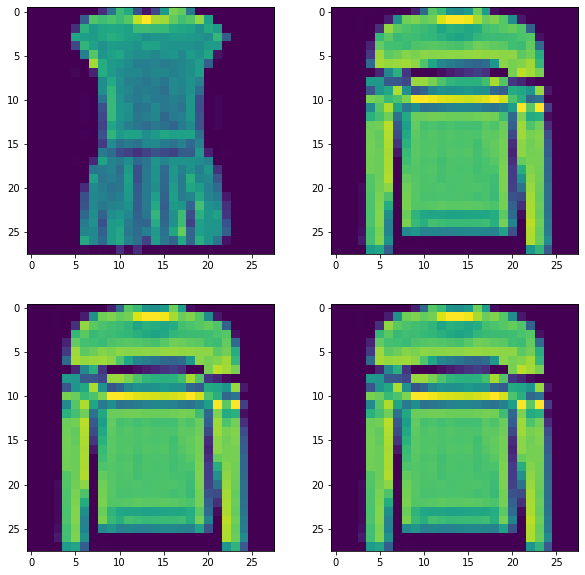

In [267]:
# Visualize some random data =
plt.figure(figsize=(10,10))
images = [train_X[int(i * 10)] for i in np.random.rand(4)]
plt.subplot(221),plt.imshow(images[0])
plt.subplot(222),plt.imshow(images[1])
plt.subplot(223),plt.imshow(images[2])
plt.subplot(224),plt.imshow(images[3])

In [284]:
# Split training and validation set
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_y, test_size=0.1)
(train_X.shape, train_y.shape), (val_X.shape, val_y.shape)

(((54000, 28, 28), (60000,)), ((6000, 28, 28), torch.Size([6000])))

In [285]:
# Convert Images into Torch format - using reshape
train_x = train_X.reshape(54000, 1, 28, 28)
train_x = torch.from_numpy(train_x)


# Comvert target into torch format
train_y = train_Y.astype(int)
train_y = torch.from_numpy(train_y)

train_X.shape, train_y.shape

((54000, 28, 28), torch.Size([54000]))

In [286]:
val_x = val_X.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_Y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_X.shape, val_y.shape

((6000, 28, 28), torch.Size([6000]))

#### Model Implementation

In [287]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )
    
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [288]:
# Define the Model
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [289]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
#     if torch.cuda.is_available():
#         x_train = x_train.cuda()
#         y_train = y_train.cuda()
#         x_val = x_val.cuda()
#         y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [291]:
# defining the number of epochs
n_epochs = 5
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(1.6267, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(1.7097, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(1.6273, grad_fn=<NllLossBackward>)


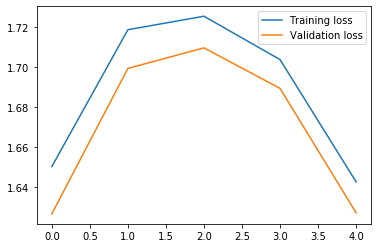

In [293]:
# Plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [296]:
# Check Accuracy of the model
with torch.no_grad():
    output = model(train_x.cpu())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

accuracy_score(train_y, predictions)

0.486

In [297]:
with torch.no_grad():
    output = model(val_x.cpu())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

accuracy_score(val_y, predictions)

0.492

In [300]:
# Generate Predictions for the test set
test_img = []
for id in tqdm(test['id']):
    image_path =  os.path.join(os.getcwd(), DATASET_DIR, APPAREL_DATASET, 'test', str(id)) + IMAGE_EXT
    #read the image
    with Image.open(image_path) as image:
        image = image.convert('L')
        image = image.convert('F')
        numpy_img = np.array(image)        
        test_img.append(numpy_img)


100%|██████████| 10000/10000 [00:19<00:00, 505.61it/s]


In [317]:
# convert the list to numpy array
test_x = np.array(test_img)
# no test_y because that's what we will be predicting. 

(<matplotlib.axes._subplots.AxesSubplot at 0x1a432d5550>,
 <matplotlib.image.AxesImage at 0x1a451fbeb8>)

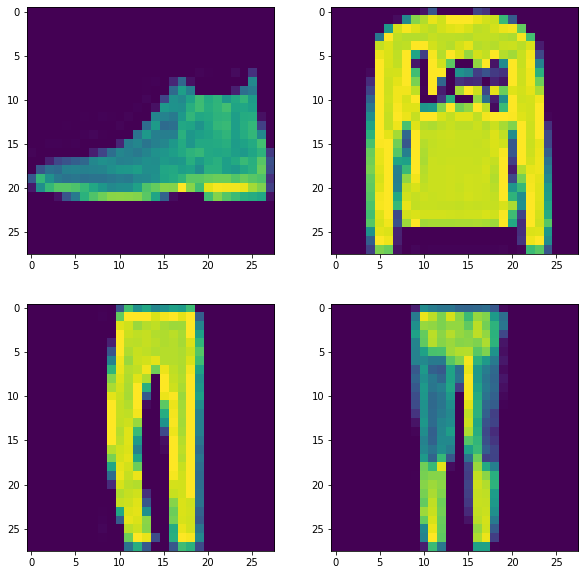

In [318]:
plt.figure(figsize=(10,10))
plt.subplot(221),plt.imshow(test_x[0])
plt.subplot(222),plt.imshow(test_x[1])
plt.subplot(223),plt.imshow(test_x[2])
plt.subplot(224),plt.imshow(test_x[3])

In [312]:
# convert test images into torch format
test_x = test_x.reshape(10000, 1, 28, 28)
test_x = torch.from_numpy(test_x)

In [315]:
# generate predictions for test set
with torch.no_grad():
    output = model(test_x.cpu())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
print(predictions)

[9 4 1 ... 3 1 6]


TypeError: Invalid shape (1, 28, 28) for image data

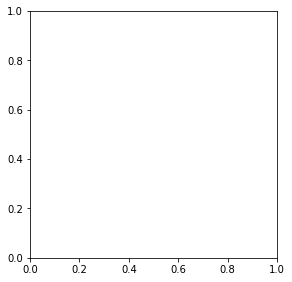